# PyMC for Bayesian A/B Test with Decision-Time Forecasting

We want to evaluate whether a new feature improves booking rate.

We:
- Use historical data to construct a prior for control
- Observe partial outcomes in the test group
- Forecast how evidence will accumulate over time
- Estimate the day we can make a confident decision

Decision rule:
- Declare success if P(p_test > p_control) ≥ 95%


In [1]:
# BASE LIBRARIES
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

c:\anaconda\envs\pymc_env\lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
# KNOWN DATA
# ---------------------------
# Historical (control)
# ---------------------------
control_applicants = 1000
control_booked = 200
control_rejected = 800

# ---------------------------
# Test (current snapshot: day 2)
# ---------------------------
test_booked = 100
test_rejected = 100
test_in_progress = 200

observed_test = np.array(
    [1] * test_booked +
    [0] * test_rejected
)

# ---------------------------
# Experiment parameters
# ---------------------------
daily_applicants = 200
total_days = 14
decision_threshold = 0.95


In [3]:
# Beysian Model
with pm.Model() as ab_model:

    # Control prior (informed by historical data)
    p_control = pm.Beta(
        "p_control",
        alpha=control_booked + 1,
        beta=control_rejected + 1
    )

    # Test prior (weak / neutral)
    p_test = pm.Beta(
        "p_test",
        alpha=1,
        beta=1
    )

    # Likelihood (only observed outcomes)
    pm.Bernoulli(
        "obs_test",
        p=p_test,
        observed=observed_test
    )

    trace = pm.sample(
        draws=2000,
        tune=1000,
        cores=1,
        target_accept=0.9
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_control, p_test]


c:\anaconda\envs\pymc_env\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\anaconda\envs\pymc_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


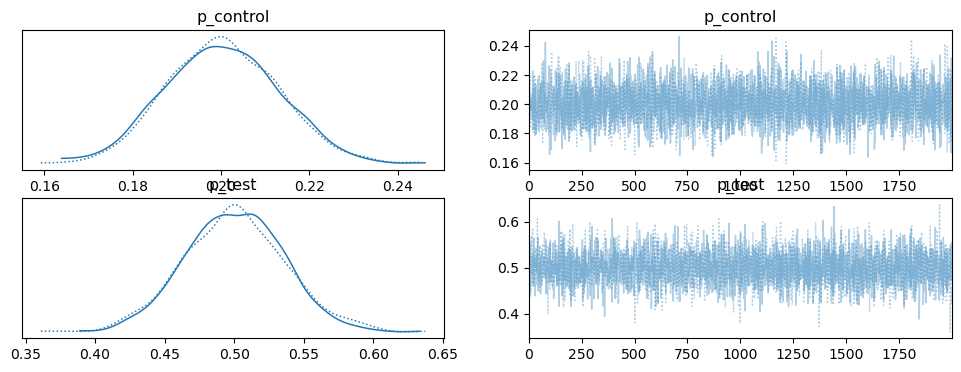

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_control,0.2,0.013,0.177,0.224,0.000,0.000,4438.0,2749.0,1.0
p_test,0.5,0.036,0.431,0.565,0.001,0.001,3884.0,2752.0,1.0


In [4]:
# Posterior Diagnostics
az.plot_trace(trace, var_names=["p_control", "p_test"])
plt.show()

az.summary(trace, var_names=["p_control", "p_test"])


In [5]:
# Probability test beats control
p_test_samples = trace.posterior["p_test"].values.flatten()
p_control_samples = trace.posterior["p_control"].values.flatten()

prob_test_better = np.mean(p_test_samples > p_control_samples)
prob_test_better


np.float64(1.0)

In [6]:
# forecasting future decision day (core logic)
# simulate future data using posterior samples of p_test and ask
# - on which day does P(p_test > p_control) cross 95%?
# simulation function
def simulate_decision_day(
    p_control_samples,
    p_test_samples,
    observed_successes,
    observed_failures,
    daily_n,
    max_days,
    threshold
):
    decision_days = []

    for i in range(len(p_test_samples)):
        p_c = p_control_samples[i]
        p_t = p_test_samples[i]

        successes = observed_successes
        failures = observed_failures

        for day in range(3, max_days + 1):
            new_outcomes = np.random.binomial(daily_n, p_t)
            successes += new_outcomes
            failures += daily_n - new_outcomes

            # Posterior update (closed-form Beta)
            alpha_t = 1 + successes
            beta_t = 1 + failures

            p_t_draw = np.random.beta(alpha_t, beta_t)
            p_c_draw = np.random.beta(
                control_booked + 1,
                control_rejected + 1
            )

            if p_t_draw > p_c_draw:
                prob = 1  # win for this draw
            else:
                prob = 0

            if prob >= threshold:
                decision_days.append(day)
                break
        else:
            decision_days.append(np.nan)

    return np.array(decision_days)


In [7]:
# run decision-time simulation
decision_days = simulate_decision_day(
    p_control_samples,
    p_test_samples,
    observed_successes=test_booked,
    observed_failures=test_rejected,
    daily_n=daily_applicants,
    max_days=total_days,
    threshold=decision_threshold
)


In [8]:
# results and interpretation
valid_days = decision_days[~np.isnan(decision_days)]

print(f"Probability of deciding before day {total_days}: {len(valid_days)/len(decision_days):.2%}")
print(f"Expected decision day: {np.mean(valid_days):.2f}")
print(f"Median decision day: {np.median(valid_days):.0f}")


Probability of deciding before day 14: 100.00%
Expected decision day: 3.00
Median decision day: 3


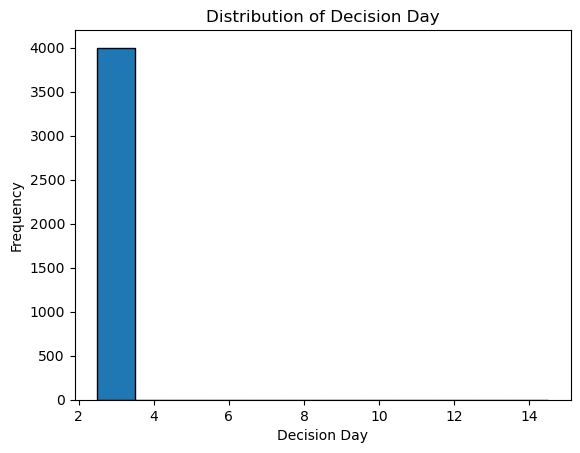

In [9]:
# visualization
plt.hist(valid_days, bins=range(3, total_days + 2), align="left", edgecolor="black")
plt.xlabel("Decision Day")
plt.ylabel("Frequency")
plt.title("Distribution of Decision Day")
plt.show()
